# Responsible Data Science Spring 2022: Homework 1

In [1]:
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables

Cloning into 'superquail'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 1), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), done.
     |████████████████████████████████| 165 kB 16.0 MB/s 
     |████████████████████████████████| 2.6 MB 15.3 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=ede777e400c899abba6a0181322aa0531f306dc2f7ab8362b178be5a098935db
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
Successfully built BlackBoxAuditing
     |████████████████████████████████| 92.6 MB 1.3 MB/s 
     |████████████████████████████████| 3.2 MB 43.1 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 367 kB 55.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing insta

In [2]:
import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from aif360.datasets import BinaryLabelDataset, StandardDataset, Dataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

import BlackBoxAuditing
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Problem 2
### **Load and split data** 

#### Load Folktables dataset and set the protected attribute, drop the other protected attribute race


We have included code to read in the folktables dataset. The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as is for the following analyses.

For more information on the this dataset, please see the following paper:
https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [3]:
np.random.seed(13)
protected_attr = 'SEX' #set sex as the protected attribute
target = 'PINCP' #personal income as the target (1=(>50k))

#read in the folktables dataset 
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)
full_df = full_df.drop(columns='RAC1P') #drop race -- another protected attribute from our dataset

print(full_df.shape)
full_df.head()

(70000, 10)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,44.0,1.0,1.0,1.0,4220.0,6.0,10.0,40.0,1.0,0.0
1,66.0,2.0,20.0,2.0,4720.0,42.0,0.0,32.0,2.0,0.0
2,72.0,6.0,18.0,1.0,10.0,6.0,1.0,8.0,2.0,1.0
3,53.0,1.0,21.0,1.0,1460.0,457.0,0.0,40.0,1.0,1.0
4,55.0,1.0,16.0,1.0,220.0,6.0,1.0,40.0,1.0,0.0


In [4]:
# convert this dataframe into an aif360 dataset
dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

### Create the train test val split

In [5]:
#YOUR CODE HERE

# Split original data into train and test data (0.8:0.2)
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True)
# Split training data in to training and validation data for hyperparameter tuning (0.2:0.1)
train_orig, val_orig = train_orig.split([0.875], shuffle=True)

# Convert to dataframes
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

print("Train set: ", train_orig_df.shape)
print("Val set: ", val_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (49000, 10)
Val set:  (7000, 10)
Test set:  (14000, 10)


# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) model and report metrics**

### Train a random forest model - Baseline

In [6]:
#YOUR CODE HERE

x_train = train_orig_df.drop([target], axis=1)
y_train = train_orig_df.PINCP

# Baseline random forest model
initial_rf = RandomForestClassifier(random_state=10)
    
# Fit the model using the training data
initial_rf = initial_rf.fit(x_train, y_train, sample_weight=None)

### Calculate Metrics

In [7]:
# Evaluate the accuracy and AUC

def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained random forest classifier model'''
    
    # Calculate predicted values
    y_pred = model.predict_proba(X)
    # This returns a tuple for each observation containing the probability of being in each class.
    # Since we're doing binary classification, all we need to know is the probability that the outcome = 1 (high income)
    y_pred = [row[1] for row in y_pred] # This pulls the predicted probability that y = 1 for each observation

    # Calculate accuracy
    accuracy = accuracy_score(y_true, [pred_prob >= 0.5 for pred_prob in y_pred])

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, auc

In [8]:
#YOUR CODE HERE

x_test = test_orig_df.drop([target], axis=1)
y_test = test_orig_df.PINCP

# Overall accuracy and AUC
accuracy, auc = evaluate(initial_rf, x_test, y_test)
print("Overall accuracy and AUC")
print("Accuracy: ", accuracy)
print("AUC: ", auc)

test_privileged = test_orig_df[test_orig_df['SEX'] == 1.0]
x_privileged = test_privileged.drop([target], axis=1)
y_privileged = test_privileged.PINCP

# Accuracy for the privileged group
accuracy, auc = evaluate(initial_rf, x_privileged, y_privileged)
print("\nAccuracy for the privileged group")
print("Accuracy: ", accuracy)

test_unprivileged = test_orig_df[test_orig_df['SEX'] == 2.0]
x_unprivileged = test_unprivileged.drop([target], axis=1)
y_unprivileged = test_unprivileged.PINCP

# Accuracy for the unprivileged group
accuracy, auc = evaluate(initial_rf, x_unprivileged, y_unprivileged)
print("\nAccuracy for the unprivileged group")
print("Accuracy: ", accuracy)

Overall accuracy and AUC
Accuracy:  0.809
AUC:  0.8870013710914366

Accuracy for the privileged group
Accuracy:  0.8002695417789757

Accuracy for the unprivileged group
Accuracy:  0.8188449848024316


In [9]:
# Calculate the disparate impact

metric_test = BinaryLabelDatasetMetric(
     test_orig, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Disparate Impact = %f" % metric_test.disparate_impact())

Disparate Impact = 0.763941


In [10]:
# Calculate the false positive rate difference

test_preds_df = test_orig_df.copy()
test_preds_df['PINCP'] = initial_rf.predict(x_test)

orig_aif360 = StandardDataset(test_orig_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                privileged_classes=[[1]], favorable_classes=[1])
preds_aif360 = StandardDataset(test_preds_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                privileged_classes=[[1]], favorable_classes=[1])

orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("False positive rate for the priviledged group = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for the unpriviledged group = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate difference = %f" % orig_vs_preds_metrics.false_positive_rate_difference())

False positive rate for the priviledged group = 0.185167
False positive rate for the unpriviledged group = 0.129199
False positive rate difference = -0.055968


# Problem 2, Part (b)
### **Hyperparameter tuning of baseline RF model**

In [11]:
# for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

### Define a program to conduct tune the Random Forest
Optimize the AUC. You should try the following hyperparameters: <br>
max_depth=[1, 5, 10] <br>
n_estimators=[1, 5, 10, 15, 20]

In [12]:
# Random forest hyperparameter tuning

def tune_random_forest(train_df, val_df, max_depth, n_estimators, verbose=True):
    '''Tunes random forest models over the hyperparameters max_depth and n_estimators
       to maximize the accuracy'''
    # Pre-process the training and validation data
    x_train = train_df.drop([target], axis=1)
    y_train = train_df.PINCP.replace({2:0}) 
    x_val = val_df.drop([target], axis=1)
    y_val = val_df.PINCP.replace({2:0})     

    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_acc = []
    
    # Loop through the hyperparameters of interest

    for depth in max_depth:
      for tree in n_estimators:
            # Train the random forest model with the given hyperparameters
            rf = RandomForestClassifier(max_depth=depth, n_estimators=tree)

            # Fit the model using the training data
            rf = rf.fit(x_train, y_train, sample_weight=None)

            # Get the evalution metrics on the validation set
            accuracy, auc = evaluate(rf, x_val, y_val)

            # Store the results
            parameters.append({'max_depth': depth, 'n_estimators': tree})
            models.append(rf)
            val_acc.append(accuracy)

            # Print the results
            if verbose:
                print("\nParmeters: \tmax_depth={} \tn_estimators={}".format(depth, tree))
                print("Validtion Accuracy: {}".format(accuracy))            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(val_acc)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model accuracy: ", val_acc[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_acc

In [13]:
#YOUR CODE HERE

best_lr, parameters, models, val_acc = tune_random_forest(train_orig_df, val_orig_df, max_depth=[1, 5, 10], n_estimators=[1, 5, 10, 15, 20])


Parmeters: 	max_depth=1 	n_estimators=1
Validtion Accuracy: 0.6224285714285714

Parmeters: 	max_depth=1 	n_estimators=5
Validtion Accuracy: 0.7282857142857143

Parmeters: 	max_depth=1 	n_estimators=10
Validtion Accuracy: 0.728

Parmeters: 	max_depth=1 	n_estimators=15
Validtion Accuracy: 0.7407142857142858

Parmeters: 	max_depth=1 	n_estimators=20
Validtion Accuracy: 0.7501428571428571

Parmeters: 	max_depth=5 	n_estimators=1
Validtion Accuracy: 0.7568571428571429

Parmeters: 	max_depth=5 	n_estimators=5
Validtion Accuracy: 0.7928571428571428

Parmeters: 	max_depth=5 	n_estimators=10
Validtion Accuracy: 0.7932857142857143

Parmeters: 	max_depth=5 	n_estimators=15
Validtion Accuracy: 0.7928571428571428

Parmeters: 	max_depth=5 	n_estimators=20
Validtion Accuracy: 0.7907142857142857

Parmeters: 	max_depth=10 	n_estimators=1
Validtion Accuracy: 0.7895714285714286

Parmeters: 	max_depth=10 	n_estimators=5
Validtion Accuracy: 0.8107142857142857

Parmeters: 	max_depth=10 	n_estimators=10
Va

###Best hyperparameters and accuracy###
+ max_depth: 10
+ n_estimators: 20
+ accuracy: 0.8158571428571428

### Compare the initial model to the fine-tuned model for 10 train/val/test splits for Random Forest

In [14]:
#YOUR CODE HERE

# Metrics array
init_accuracy = []
init_acc_priv = []
init_acc_unpr = []
init_di = []
init_fprd = []

# 10 iterations of splits
for i in range(1,11):
    print("\nSplit iteration: ", i)
    train_splits, test_splits = dataset_orig.split([0.8], shuffle=True)
    train_splits, val_splits = train_splits.split([0.875], shuffle=True)
    train_splits_df, _ = train_splits.convert_to_dataframe()
    val_splits_df, _ = val_splits.convert_to_dataframe()
    test_splits_df, _ = test_splits.convert_to_dataframe()

    x_train = train_splits_df.drop([target], axis=1)
    y_train = train_splits_df.PINCP
    x_test = test_splits_df.drop([target], axis=1)
    y_test = test_splits_df.PINCP

    temp_rf = RandomForestClassifier()
    temp_rf = temp_rf.fit(x_train, y_train, sample_weight=None)

    accuracy, _ = evaluate(temp_rf, x_test, y_test)
    init_accuracy.append(accuracy)
    print("Overall accuracy: ", accuracy)

    test_priv_splits = test_splits_df[test_splits_df['SEX'] == 1.0]
    x_priv_splits = test_priv_splits.drop([target], axis=1)
    y_priv_splits = test_priv_splits.PINCP
    accuracy, _ = evaluate(temp_rf, x_priv_splits, y_priv_splits)
    init_acc_priv.append(accuracy)
    print("Accuracy for the privileged group: ", accuracy)

    test_unpr_splits = test_splits_df[test_splits_df['SEX'] == 2.0]
    x_unpr_splits = test_unpr_splits.drop([target], axis=1)
    y_unpr_splits = test_unpr_splits.PINCP
    accuracy, _ = evaluate(temp_rf, x_unpr_splits, y_unpr_splits)
    init_acc_unpr.append(accuracy)
    print("Accuracy for the unprivileged group", accuracy)

    metric_splits = BinaryLabelDatasetMetric(
         test_splits, 
         unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups
      )
    print("Disparate Impact = %f" % metric_splits.disparate_impact())
    init_di.append(metric_splits.disparate_impact())

    test_preds_df = test_splits_df.copy()
    test_preds_df['PINCP'] = temp_rf.predict(x_test)
    orig_aif360 = StandardDataset(test_splits_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                    privileged_classes=[[1]], favorable_classes=[1])
    preds_aif360 = StandardDataset(test_preds_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                    privileged_classes=[[1]], favorable_classes=[1])
    orig_vs_preds_splits_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
    print("False positive rate difference = %f" % orig_vs_preds_splits_metrics.false_positive_rate_difference())
    init_fprd.append(orig_vs_preds_splits_metrics.false_positive_rate_difference())



Split iteration:  1
Overall accuracy:  0.8067142857142857
Accuracy for the privileged group:  0.800983472203251
Accuracy for the unprivileged group 0.8129959574786645
Disparate Impact = 0.736759
False positive rate difference = -0.051261

Split iteration:  2
Overall accuracy:  0.8069285714285714
Accuracy for the privileged group:  0.802745367192862
Accuracy for the unprivileged group 0.8114668652271035
Disparate Impact = 0.756807
False positive rate difference = -0.058049

Split iteration:  3
Overall accuracy:  0.8042142857142857
Accuracy for the privileged group:  0.7980994353394849
Accuracy for the unprivileged group 0.8108027897314142
Disparate Impact = 0.735963
False positive rate difference = -0.056891

Split iteration:  4
Overall accuracy:  0.8107142857142857
Accuracy for the privileged group:  0.8029347229840922
Accuracy for the unprivileged group 0.8191711389385808
Disparate Impact = 0.727448
False positive rate difference = -0.038949

Split iteration:  5
Overall accuracy:  0.

In [15]:
# Metrics array
tuned_accuracy = []
tuned_acc_priv = []
tuned_acc_unpr = []
tuned_di = []
tuned_fprd = []

# 10 iterations of splits after hyperparameter tuning
for i in range(1,11):
    print("\nSplit after hyperparameter tuning iteration: ", i)
    train_splits, test_splits = dataset_orig.split([0.8], shuffle=True)
    train_splits, val_splits = train_splits.split([0.875], shuffle=True)
    train_splits_df, _ = train_splits.convert_to_dataframe()
    val_splits_df, _ = val_splits.convert_to_dataframe()
    test_splits_df, _ = test_splits.convert_to_dataframe()

    x_train = train_splits_df.drop([target], axis=1)
    y_train = train_splits_df.PINCP
    x_test = test_splits_df.drop([target], axis=1)
    y_test = test_splits_df.PINCP

    temp_rf = RandomForestClassifier(max_depth=10, n_estimators=20)
    temp_rf = temp_rf.fit(x_train, y_train, sample_weight=None)

    accuracy, _ = evaluate(temp_rf, x_test, y_test)
    tuned_accuracy.append(accuracy)
    print("Overall accuracy: ", accuracy)

    test_priv_splits = test_splits_df[test_splits_df['SEX'] == 1.0]
    x_priv_splits = test_priv_splits.drop([target], axis=1)
    y_priv_splits = test_priv_splits.PINCP
    accuracy, _ = evaluate(temp_rf, x_priv_splits, y_priv_splits)
    tuned_acc_priv.append(accuracy)
    print("Accuracy for the privileged group: ", accuracy)

    test_unpr_splits = test_splits_df[test_splits_df['SEX'] == 2.0]
    x_unpr_splits = test_unpr_splits.drop([target], axis=1)
    y_unpr_splits = test_unpr_splits.PINCP
    accuracy, _ = evaluate(temp_rf, x_unpr_splits, y_unpr_splits)
    tuned_acc_unpr.append(accuracy)
    print("Accuracy for the unprivileged group", accuracy)

    metric_splits = BinaryLabelDatasetMetric(
         test_splits, 
         unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups
      )
    print("Disparate Impact = %f" % metric_splits.disparate_impact())
    tuned_di.append(metric_splits.disparate_impact())

    test_preds_df = test_splits_df.copy()
    test_preds_df['PINCP'] = temp_rf.predict(x_test)
    orig_aif360 = StandardDataset(test_splits_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                    privileged_classes=[[1]], favorable_classes=[1])
    preds_aif360 = StandardDataset(test_preds_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                    privileged_classes=[[1]], favorable_classes=[1])
    orig_vs_preds_splits_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
    print("False positive rate difference = %f" % orig_vs_preds_splits_metrics.false_positive_rate_difference())
    tuned_fprd.append(orig_vs_preds_splits_metrics.false_positive_rate_difference())



Split after hyperparameter tuning iteration:  1
Overall accuracy:  0.8154285714285714
Accuracy for the privileged group:  0.8070056802813091
Accuracy for the unprivileged group 0.8248561913412049
Disparate Impact = 0.767548
False positive rate difference = -0.065488

Split after hyperparameter tuning iteration:  2
Overall accuracy:  0.8094285714285714
Accuracy for the privileged group:  0.8034199542210853
Accuracy for the unprivileged group 0.8162178609462954
Disparate Impact = 0.799102
False positive rate difference = -0.065488

Split after hyperparameter tuning iteration:  3
Overall accuracy:  0.808
Accuracy for the privileged group:  0.8020346439373109
Accuracy for the unprivileged group 0.8144513826940232
Disparate Impact = 0.743811
False positive rate difference = -0.045498

Split after hyperparameter tuning iteration:  4
Overall accuracy:  0.8139285714285714
Accuracy for the privileged group:  0.8084671930302205
Accuracy for the unprivileged group 0.8199579200480914
Disparate Im

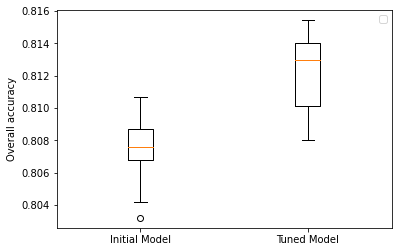

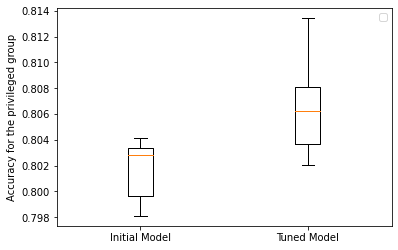

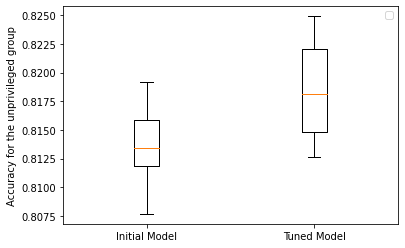

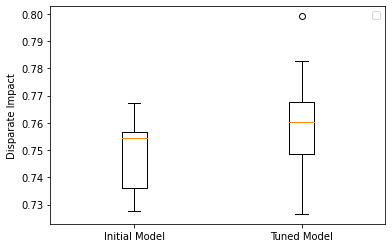

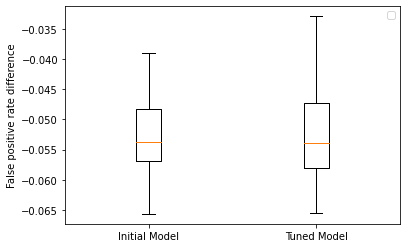

In [16]:
plot_init_v_tuned_box(init_accuracy, tuned_accuracy, "Overall accuracy")
plot_init_v_tuned_box(init_acc_priv, tuned_acc_priv, "Accuracy for the privileged group")
plot_init_v_tuned_box(init_acc_unpr, tuned_acc_unpr, "Accuracy for the unprivileged group")
plot_init_v_tuned_box(init_di, tuned_di, "Disparate Impact")
plot_init_v_tuned_box(init_fprd, tuned_fprd, "False positive rate difference")

# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

In [17]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, x_label='Repair level'):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

### Apply pre-processing techniques to the dataset, then re-train the models with the optimal hyperparameters from part **b**

In [18]:
#YOUR CODE HERE

# Disparate Impact Remover

# Repair levels
repairs = [0.2, 0.4, 0.6, 0.8, 1.0]

# Metrics array
DI_accuracy = []
DI_acc_priv = []
DI_acc_unpr = []
DI_di = []
DI_fprd = []

for i in range(len(repairs)):
    print("\nRepair level : ", repairs[i])
    di = DisparateImpactRemover(repair_level=repairs[i])
    dataset_DI = di.fit_transform(dataset_orig)
    
    train_DI, test_DI = dataset_DI.split([0.8], shuffle=True)
    train_DI, val_DI = train_DI.split([0.875], shuffle=True)
    train_DI_df, _ = train_DI.convert_to_dataframe()
    val_DI_df, _ = val_DI.convert_to_dataframe()
    test_DI_df, _ = test_DI.convert_to_dataframe()

    x_train = train_DI_df.drop([target], axis=1)
    y_train = train_DI_df.PINCP
    x_test = test_DI_df.drop([target], axis=1)
    y_test = test_DI_df.PINCP

    DI_rf = RandomForestClassifier(max_depth=10, n_estimators=20)
    DI_rf = DI_rf.fit(x_train, y_train, sample_weight=None)
    
    accuracy, _ = evaluate(DI_rf, x_test, y_test)
    DI_accuracy.append(accuracy)
    print("Overall accuracy: ", accuracy)

    test_priv_DI = test_DI_df[test_DI_df['SEX'] == 1.0]
    x_priv_DI = test_priv_DI.drop([target], axis=1)
    y_priv_DI = test_priv_DI.PINCP
    accuracy, _ = evaluate(DI_rf, x_priv_DI, y_priv_DI)
    DI_acc_priv.append(accuracy)
    print("Accuracy for the privileged group: ", accuracy)

    test_unpr_DI = test_DI_df[test_DI_df['SEX'] == 2.0]
    x_unpr_DI = test_unpr_DI.drop([target], axis=1)
    y_unpr_DI = test_unpr_DI.PINCP
    accuracy, _ = evaluate(DI_rf, x_unpr_DI, y_unpr_DI)
    DI_acc_unpr.append(accuracy)
    print("Accuracy for the unprivileged group", accuracy)

    metric_DI = BinaryLabelDatasetMetric(
         test_DI, 
         unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups
      )
    print("Disparate Impact = %f" % metric_DI.disparate_impact())
    DI_di.append(metric_DI.disparate_impact())

    test_preds_df = test_DI_df.copy()
    test_preds_df['PINCP'] = DI_rf.predict(x_test)
    orig_aif360 = StandardDataset(test_DI_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                    privileged_classes=[[1]], favorable_classes=[1])
    preds_aif360 = StandardDataset(test_preds_df, label_name='PINCP', protected_attribute_names=['SEX'], 
                    privileged_classes=[[1]], favorable_classes=[1])
    orig_vs_preds_DI_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
    print("False positive rate difference = %f" % orig_vs_preds_DI_metrics.false_positive_rate_difference())
    DI_fprd.append(orig_vs_preds_DI_metrics.false_positive_rate_difference())



Repair level :  0.2
Overall accuracy:  0.8112142857142857
Accuracy for the privileged group:  0.8109830508474576
Accuracy for the unprivileged group 0.8114716981132075
Disparate Impact = 0.749218
False positive rate difference = -0.043809

Repair level :  0.4
Overall accuracy:  0.8097857142857143
Accuracy for the privileged group:  0.7995981245813798
Accuracy for the unprivileged group 0.8214231063504208
Disparate Impact = 0.776279
False positive rate difference = -0.058846

Repair level :  0.6
Overall accuracy:  0.8087857142857143
Accuracy for the privileged group:  0.7995954146999326
Accuracy for the unprivileged group 0.8191343963553531
Disparate Impact = 0.774339
False positive rate difference = -0.059828

Repair level :  0.8
Overall accuracy:  0.807
Accuracy for the privileged group:  0.8012056262558607
Accuracy for the unprivileged group 0.8136189747513389
Disparate Impact = 0.751296
False positive rate difference = -0.059344

Repair level :  1.0
Overall accuracy:  0.80821428571

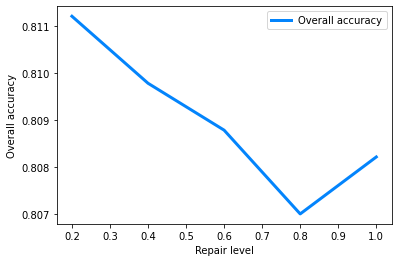

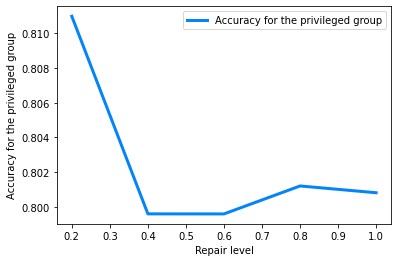

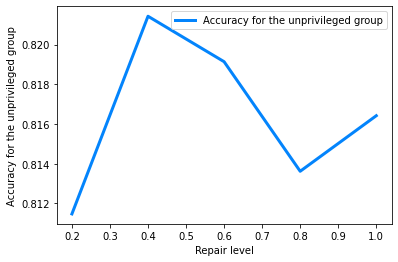

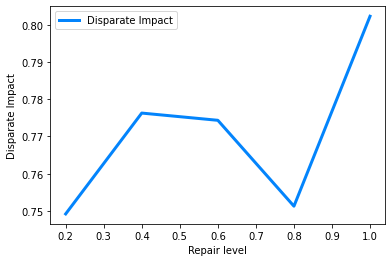

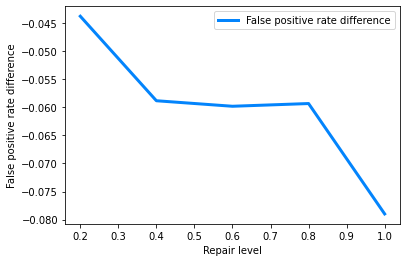

In [19]:
plot_repair_levels(repairs, DI_accuracy, "Overall accuracy", x_label='Repair level')
plot_repair_levels(repairs, DI_acc_priv, "Accuracy for the privileged group", x_label='Repair level')
plot_repair_levels(repairs, DI_acc_unpr, "Accuracy for the unprivileged group", x_label='Repair level')
plot_repair_levels(repairs, DI_di, "Disparate Impact", x_label='Repair level')
plot_repair_levels(repairs, DI_fprd, "False positive rate difference", x_label='Repair level')

# Problem 2, Part (d) 
### **Prejudice Remover In-Processing intervention**



In [20]:
def plot_eta_parameter(eta, metric_vals, metric_name, x_label='eta parameter'):
  '''Creates a line plot showing how the metric changed for different values of eta'''

  # Plot the metrics
  plt.plot(eta, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

### Fit new models using the Prejudice Remover technique

In [ ]:
#YOUR CODE HERE

etas = [0.01, 0.1, 1]

PR_accuracy = []
PR_di = []


# Prejudice Remover
for eta in etas:
    print("\neta : ", eta)
    pr = PrejudiceRemover(eta=eta)

    train_PR = pr.fit(train_splits)
    test_pred_PR = pr.predict(test_splits)
    val_pred_PR = pr.predict(val_splits)

    accuracy = accuracy_score(test_splits_df.PINCP, test_pred_PR.labels)
    PR_accuracy.append(accuracy)
    print("Overall accuracy: ", accuracy)

    metric_PR = BinaryLabelDatasetMetric(
         test_pred_PR, 
         unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups
      )
    print("Disparate Impact = %f" % metric_PR.disparate_impact())
    PR_di.append(metric_PR.disparate_impact())




eta :  0.01


In [ ]:
plot_eta_parameter(etas, PR_accuracy, "Overall accuracy", x_label='eta')
plot_eta_parameter(etas, PR_di, "Disparate Impact", x_label='eta')

# Problem 2, Part (e) 
### **Reject Option Post-Processing intervention**

### Using the same random forest models as before, apply the post-processing technique to your results and compare

In [274]:
#YOUR CODE HERE

x_val = val_splits_df.drop([target], axis=1)
y_val = val_splits_df.PINCP

temp_rf = temp_rf.fit(x_val, y_val, sample_weight=None)

roc_score = temp_rf.predict_proba(x_val)
# roc_score = [row[1] for row in roc_score]

In [275]:
val_roc = val_splits.copy()
val_roc.scores = roc_score

In [286]:
roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
roc = roc.fit(val_roc, val_roc)

ValueError: ignored